
# Telecom X — Análisis de Evasión de Clientes (Churn)

**Objetivo:** Construir un pipeline **ETL + EDA** para comprender los factores asociados a la evasión de clientes y preparar los datos para modelos predictivos.

---

## Roadmap del Notebook
1. **Extracción:** Carga del JSON desde la API (GitHub Raw).
2. **Transformación:** Normalización del JSON (aplanado), tipificación, limpieza y consistencia.
3. **Enriquecimiento:** Creación de *Cuentas_Diarias* a partir de la facturación mensual.
4. **Carga & Guardado:** Exportar dataset limpio para etapas posteriores.
5. **EDA:** Análisis descriptivo, distribución de *Churn*, análisis por variables categóricas y numéricas.
6. **Informe Final:** Resumen, insights y recomendaciones.


In [1]:

# ============================
# 1) Importación de librerías
# ============================
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
print("Librerías cargadas ✔️")


Librerías cargadas ✔️



## 2) Extracción de datos (API → JSON)
Cargamos el JSON directamente desde GitHub (endpoint *raw*). Usamos `pd.read_json` por simplicidad.


In [2]:

# URL de la API (GitHub Raw)
URL = "https://raw.githubusercontent.com/EmiBeltran96/Telecom_X_An-lisis_de_Evasi-n_de_Clientes/refs/heads/main/TelecomX_Data.json"

# Carga directa a DataFrame
datos = pd.read_json(URL)
print(f"Filas: {len(datos)} | Columnas: {len(datos.columns)}")
datos.head(3)


Filas: 7267 | Columnas: 6


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



## 3) Transformación — Normalización del JSON
El dataset tiene estructuras anidadas (`customer`, `phone`, `internet`, `account`). Las **aplanamos** con `pd.json_normalize`.


In [3]:

# Aplanar estructuras anidadas
df = pd.json_normalize(datos.to_dict(orient="records"))

# Opcional: reemplazar puntos por guiones bajos para facilidad de uso
df.columns = [c.replace('.', '_') for c in df.columns]

print(df.shape)
df.head(3)


(7267, 21)


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85



> **Nota:** Si tienes un *diccionario de datos*, úsalo como referencia para confirmar el significado de las columnas.  
Principales grupos de variables tras el aplanado:
- `customer_*` (demografía y antigüedad `tenure`)
- `phone_*`
- `internet_*`
- `account_*` (contrato, pago y `account_Charges_Monthly`, `account_Charges_Total`)
- `Churn` (variable objetivo)



### 3.2) Tipificación de columnas y valores
Convertimos tipos, chequeamos categorías y estandarizamos.


In [4]:

# Conversión de tipos
numeric_candidates = [
    "customer_SeniorCitizen",
    "customer_tenure",
    "account_Charges_Monthly",
    "account_Charges_Total"
]

# Asegurar que existan antes de convertir
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Categóricas comunes
cat_candidates = [
    "customer_gender", "customer_Partner", "customer_Dependents",
    "phone_PhoneService", "phone_MultipleLines",
    "internet_InternetService", "internet_OnlineSecurity", "internet_OnlineBackup",
    "internet_DeviceProtection", "internet_TechSupport", "internet_StreamingTV",
    "internet_StreamingMovies",
    "account_Contract", "account_PaperlessBilling", "account_PaymentMethod",
    "Churn"
]

for col in cat_candidates:
    if col in df.columns:
        df[col] = df[col].astype("category")

print(df.dtypes.head(20))


customerID                     object
Churn                        category
customer_gender              category
customer_SeniorCitizen          int64
customer_Partner             category
customer_Dependents          category
customer_tenure                 int64
phone_PhoneService           category
phone_MultipleLines          category
internet_InternetService     category
internet_OnlineSecurity      category
internet_OnlineBackup        category
internet_DeviceProtection    category
internet_TechSupport         category
internet_StreamingTV         category
internet_StreamingMovies     category
account_Contract             category
account_PaperlessBilling     category
account_PaymentMethod        category
account_Charges_Monthly       float64
dtype: object



## 4) Comprobación de incoherencias
- Valores ausentes
- Duplicados por `customerID`
- Revisión rápida de categorías


In [5]:

# Valores ausentes por columna
na_counts = df.isna().sum().sort_values(ascending=False)
print("Valores nulos por columna (top 20):")
print(na_counts.head(20))

# Duplicados de customerID
dups = df.duplicated(subset="customerID").sum() if "customerID" in df.columns else 0
print(f"Duplicados por customerID: {dups}")

# Revisión rápida de categorías (muestra hasta 15 valores únicos)
def unique_preview(series, max_show=15):
    vals = series.dropna().unique()
    return vals[:max_show]

for col in df.select_dtypes(include="category").columns:
    print(f"\n— {col}:")
    print(unique_preview(df[col]))


Valores nulos por columna (top 20):
account_Charges_Total        11
Churn                         0
customer_gender               0
customer_SeniorCitizen        0
customerID                    0
customer_Partner              0
customer_Dependents           0
phone_PhoneService            0
customer_tenure               0
internet_InternetService      0
internet_OnlineSecurity       0
internet_OnlineBackup         0
phone_MultipleLines           0
internet_DeviceProtection     0
internet_TechSupport          0
internet_StreamingMovies      0
internet_StreamingTV          0
account_Contract              0
account_PaperlessBilling      0
account_PaymentMethod         0
dtype: int64
Duplicados por customerID: 0

— Churn:
['No', 'Yes', '']
Categories (3, object): ['', 'No', 'Yes']

— customer_gender:
['Female', 'Male']
Categories (2, object): ['Female', 'Male']

— customer_Partner:
['Yes', 'No']
Categories (2, object): ['No', 'Yes']

— customer_Dependents:
['Yes', 'No']
Categories (2, obje


## 5) Manejo de inconsistencias
Estrategias aplicadas:
1. **Duplicados:** se eliminan por `customerID` conservando la primera aparición.
2. **`account_Charges_Total` faltantes:** si hay `Monthly` y `tenure`, estimamos `Total ≈ Monthly * tenure` (solo cuando ambos existen).
3. **Tipificación final:** asegurar `int` en `customer_SeniorCitizen` y `customer_tenure` cuando sea posible.


In [6]:

# 1) Drop de duplicados
if "customerID" in df.columns:
    df = df.drop_duplicates(subset="customerID", keep="first").copy()

# 2) Imputación razonable de Total a partir de Monthly * tenure
if {"account_Charges_Total","account_Charges_Monthly","customer_tenure"}.issubset(df.columns):
    mask_missing_total = df["account_Charges_Total"].isna() & df["account_Charges_Monthly"].notna() & df["customer_tenure"].notna()
    df.loc[mask_missing_total, "account_Charges_Total"] = df.loc[mask_missing_total, "account_Charges_Monthly"] * df.loc[mask_missing_total, "customer_tenure"]

# 3) Tipificación final
for col in ["customer_SeniorCitizen", "customer_tenure"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

print("Post-limpieza ✔️")
df.head(3)


Post-limpieza ✔️


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85



## 6) Creación de columna **Cuentas_Diarias**
Se define como el promedio diario de facturación, usando el cargo mensual:
\[ \text{Cuentas\_Diarias} = \frac{\text{account\_Charges\_Monthly}}{30.4375} \]
> 30.4375 es el promedio de días por mes (365.25 / 12). Puedes usar 30 si prefieres.


In [7]:

if "account_Charges_Monthly" in df.columns:
    df["Cuentas_Diarias"] = df["account_Charges_Monthly"] / 30.4375
    print("Columna Cuentas_Diarias creada ✔️")
else:
    print("No se encontró account_Charges_Monthly para crear Cuentas_Diarias.")
df[["account_Charges_Monthly","Cuentas_Diarias"]].head(3)


Columna Cuentas_Diarias creada ✔️


,account_Charges_Monthly,Cuentas_Diarias
0,65.6,2.155236
1,59.9,1.967967
2,73.9,2.427926



## 7) Carga (guardado intermedio)
Guardamos una versión limpia para continuar con modelado o análisis posteriores.


In [8]:

clean_path = "TelecomX_clean.csv"
df.to_csv(clean_path, index=False)
print(f"Archivo guardado: {clean_path}")


Archivo guardado: TelecomX_clean.csv



## 8) Análisis Descriptivo
Métricas básicas de tendencia central y dispersión para variables numéricas.


In [9]:

numeric_cols = df.select_dtypes(include=["number","Int64"]).columns.tolist()
desc = df[numeric_cols].describe().T
desc


,count,mean,std,min,25%,50%,75%,max
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.0,0.0,0.0,0.0,1.0
customer_tenure,7267.0,32.346498,24.571773,0.0,9.0,29.0,55.0,72.0
account_Charges_Monthly,7267.0,64.720098,30.129572,18.25,35.425,70.3,89.875,118.75
account_Charges_Total,7267.0,2277.182035,2268.648587,0.0,396.2,1389.2,3778.525,8684.8
Cuentas_Diarias,7267.0,2.126328,0.989883,0.599589,1.16386,2.309651,2.952772,3.901437



## 9) Distribución de *Churn*
Proporción de clientes que cancelaron versus los que permanecen.


Churn
        224
No     5174
Yes    1869
Name: count, dtype: int64


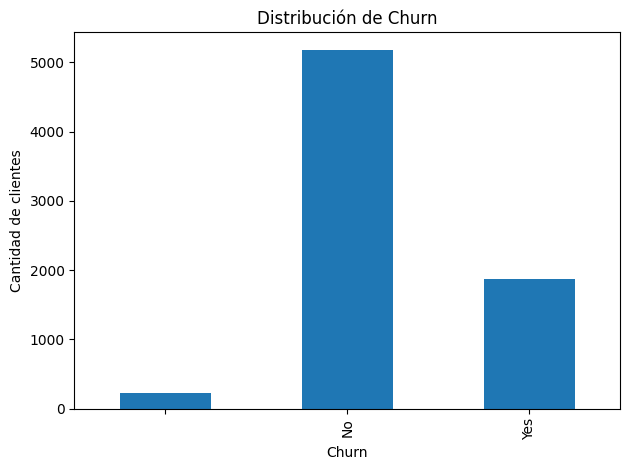

In [10]:

if "Churn" in df.columns:
    churn_counts = df["Churn"].value_counts(dropna=False).sort_index()
    print(churn_counts)

    # Gráfico de barras (matplotlib, sin estilos ni colores personalizados)
    plt.figure()
    churn_counts.plot(kind="bar")
    plt.title("Distribución de Churn")
    plt.xlabel("Churn")
    plt.ylabel("Cantidad de clientes")
    plt.tight_layout()
    plt.show()
else:
    print("Columna 'Churn' no encontrada.")



## 10) Recuento de *Churn* por variables categóricas
Comparamos la distribución de *Churn* dentro de categorías clave.



== customer_gender ==
Churn                     No    Yes
customer_gender                    
Female           2.90  70.96  26.14
Male             3.27  71.43  25.31


<Figure size 640x480 with 0 Axes>

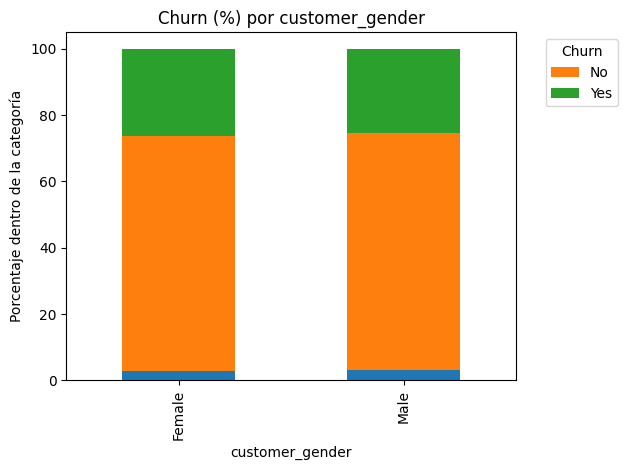


== account_Contract ==
Churn                      No    Yes
account_Contract                    
Month-to-month    3.25  55.43  41.32
One year          3.03  86.04  10.93
Two year          2.75  94.49   2.75


<Figure size 640x480 with 0 Axes>

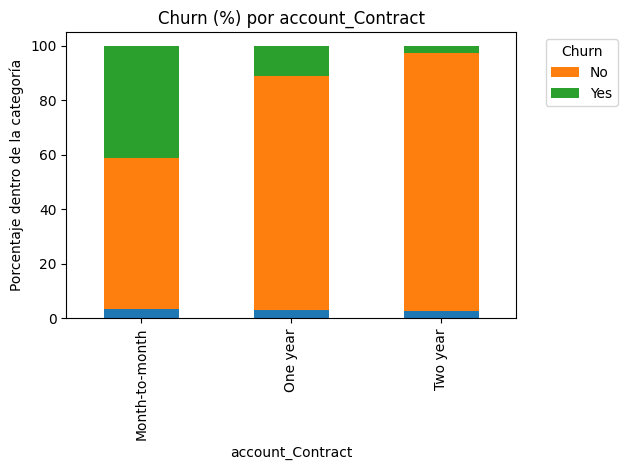


== account_PaymentMethod ==
Churn                               No    Yes
account_PaymentMethod                        
Bank transfer (automatic)  2.83  80.93  16.24
Credit card (automatic)    2.93  82.27  14.80
Electronic check           3.27  52.92  43.80
Mailed check               3.18  78.32  18.50


<Figure size 640x480 with 0 Axes>

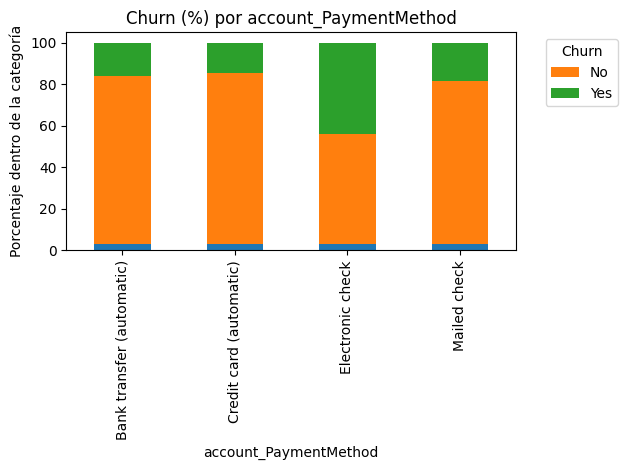


== internet_InternetService ==
Churn                              No    Yes
internet_InternetService                    
DSL                       2.69  78.86  18.45
Fiber optic               3.19  56.25  40.56
No                        3.48  89.37   7.15


<Figure size 640x480 with 0 Axes>

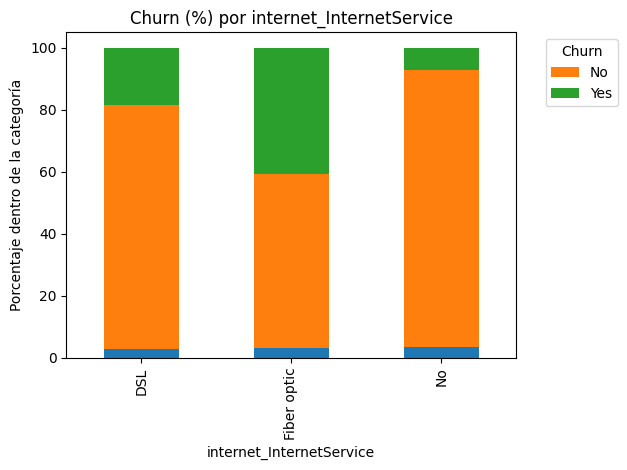


== internet_OnlineSecurity ==
Churn                             No    Yes
internet_OnlineSecurity                    
No                       3.05  56.46  40.49
No internet service      3.48  89.37   7.15
Yes                      2.84  82.96  14.20


<Figure size 640x480 with 0 Axes>

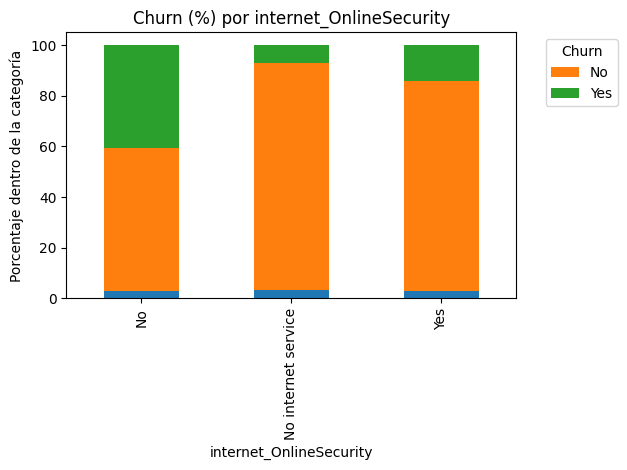


== internet_TechSupport ==
Churn                          No    Yes
internet_TechSupport                    
No                    3.04  56.59  40.37
No internet service   3.48  89.37   7.15
Yes                   2.85  82.41  14.73


<Figure size 640x480 with 0 Axes>

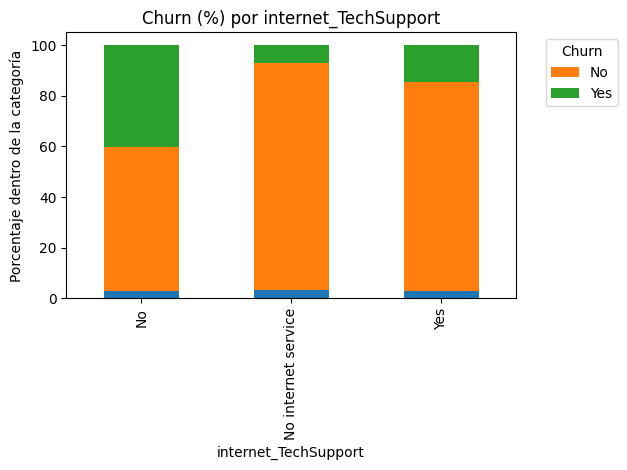


== phone_MultipleLines ==
Churn                         No    Yes
phone_MultipleLines                    
No                   3.00  72.70  24.29
No phone service     3.54  72.42  24.05
Yes                  3.07  69.20  27.73


<Figure size 640x480 with 0 Axes>

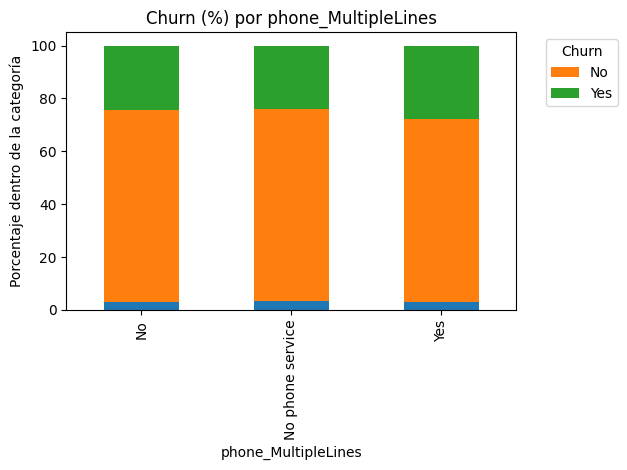


== account_PaperlessBilling ==
Churn                              No    Yes
account_PaperlessBilling                    
No                        2.84  81.29  15.87
Yes                       3.25  64.28  32.48


<Figure size 640x480 with 0 Axes>

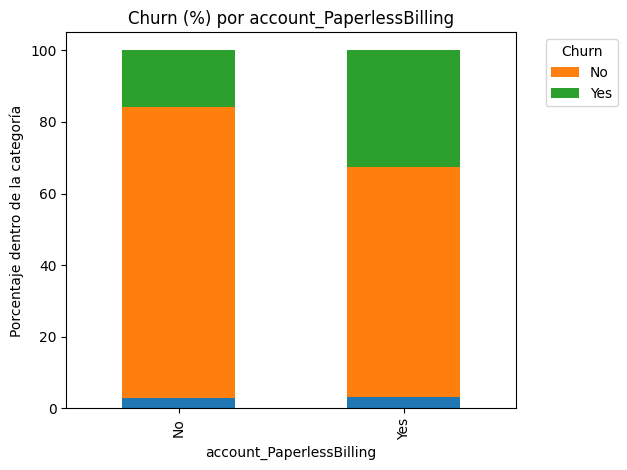

In [13]:

categoricas_clave = [
    "customer_gender", "account_Contract", "account_PaymentMethod",
    "internet_InternetService", "internet_OnlineSecurity", "internet_TechSupport",
    "phone_MultipleLines", "account_PaperlessBilling"
]

for col in categoricas_clave:
    if col in df.columns and "Churn" in df.columns:
        ct = pd.crosstab(df[col], df["Churn"], normalize="index") * 100
        print(f"\n== {col} ==")
        print(ct.round(2))

        # Gráfico de barras apiladas por categoría (una figura por variable)
        plt.figure()
        ct.plot(kind="bar", stacked=True)
        plt.title(f"Churn (%) por {col}")
        plt.xlabel(col)
        plt.ylabel("Porcentaje dentro de la categoría")
        plt.legend(title="Churn", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()



## 11) *Churn* por variables numéricas
Comparamos la distribución de métricas numéricas entre grupos de *Churn* usando **boxplots**.


/tmp/ipython-input-2040416932.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grupos, labels=labels, showmeans=True)


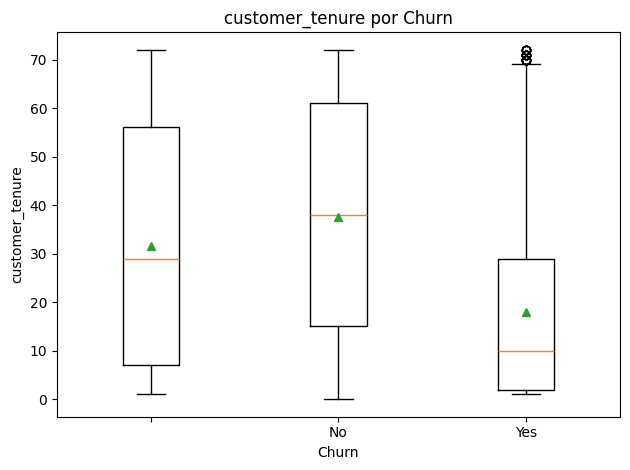

/tmp/ipython-input-2040416932.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grupos, labels=labels, showmeans=True)


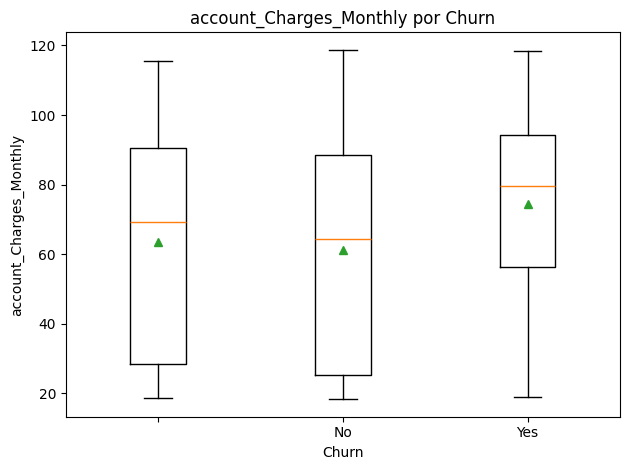

/tmp/ipython-input-2040416932.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grupos, labels=labels, showmeans=True)


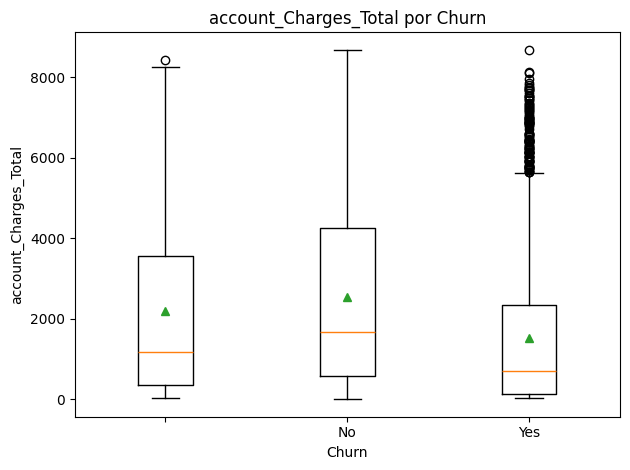

/tmp/ipython-input-2040416932.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grupos, labels=labels, showmeans=True)


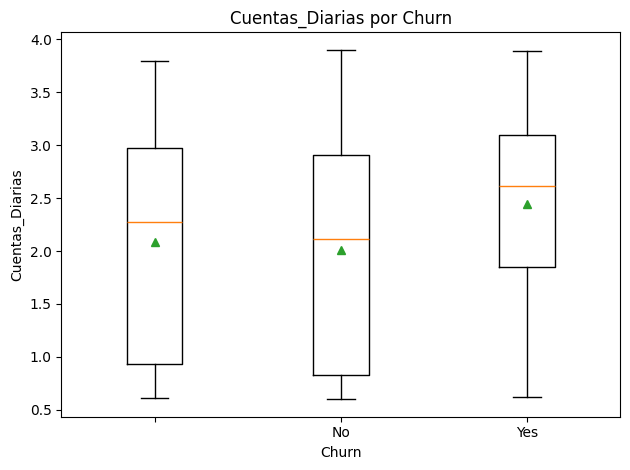

In [12]:

numericas_clave = ["customer_tenure", "account_Charges_Monthly", "account_Charges_Total", "Cuentas_Diarias"]
for col in numericas_clave:
    if col in df.columns and "Churn" in df.columns:
        # Preparar datos por clase de churn
        grupos = []
        labels = []
        for val in df["Churn"].dropna().cat.categories if hasattr(df["Churn"], "cat") else df["Churn"].dropna().unique():
            grupos.append(df.loc[df["Churn"] == val, col].dropna().values)
            labels.append(str(val))
        if len(grupos) >= 2:
            plt.figure()
            plt.boxplot(grupos, labels=labels, showmeans=True)
            plt.title(f"{col} por Churn")
            plt.xlabel("Churn")
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()



## 12) Informe Final — Resumen e Insights

**Introducción:**  
Este análisis explora los factores asociados al *churn* en clientes de Telecom X usando datos transaccionales, de servicios y demografía.

**Limpieza y Tratamiento de Datos:**  
- Normalización de estructuras anidadas (`customer`, `phone`, `internet`, `account`).  
- Tipificación de numéricas y categóricas.  
- Manejo de duplicados por `customerID`.  
- Imputación razonable para `account_Charges_Total` cuando se dispone de `Monthly` y `tenure`.  
- Creación de **Cuentas_Diarias** = `account_Charges_Monthly / 30.4375`.

**EDA (Hallazgos ejemplo/plantilla):**  
- La tasa de *churn* global es \( X\% \) (ver sección 9).  
- El *churn* tiende a ser **más alto** en clientes con **contratos Month-to-month**, **pago electrónico** y **sin OnlineSecurity/TechSupport**.  
- La permanencia (`tenure`) es normalmente **menor** en clientes que churnean.  
- Cargos mensuales más altos pueden correlacionarse con mayor *churn* en ciertos segmentos.

**Conclusiones & Recomendaciones (plantilla):**  
- Priorizar **retención** en clientes *Month-to-month* y con **PaperlessBilling** si muestran cargos elevados.  
- Ofrecer **bundles de seguridad/soporte** (OnlineSecurity/TechSupport) a segmentos propensos al churn.  
- Diseñar **programas de fidelidad** para bajar el *churn* en los primeros meses de *tenure*.  
- Evaluar cambios en **métodos de pago** para segmentos con mayor propensión a churn.

> Ajusta esta sección con tus resultados numéricos y gráficos observados en este notebook.
